In [101]:
from keras.layers import Dense, Dropout, BatchNormalization,ELU,Flatten,Conv2D
import keras.datasets as data
from keras.models import Sequential, Model
from keras.utils import to_categorical
import keras.backend as K
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import os


import numpy as np

In [88]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1
set_session(tf.Session(config=config))
import matplotlib.pyplot as plt
def plot_history(history):
    loss_values = history.history['loss']
    epochs = range(1, len(loss_values)+1)
    loss_accuracy = history.history['acc']

    plt.plot(epochs, loss_values, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.show()

    plt.plot(epochs, loss_accuracy, label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()


In [153]:
train,test = data.mnist.load_data()

In [161]:
x_train,y_train = train
x_test,y_test = test

train_mask = np.isin(y_train, [0, 4])
test_mask = np.isin(y_test, [0, 4])

x_train = x_train[train_mask]
x_test = x_test[test_mask]
y_test = y_test[test_mask]
y_train = y_train[train_mask]

y_train = to_categorical(y_train)
x_train = x_train.reshape(-1,1,28,28)
y_test = to_categorical(y_test)
x_test = x_test.reshape(-1,1,28,28)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [217]:
def create_model_simple(alpha=1.0,lr=0.001,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0):
    """
    Create model with given hyperparameters
    """
    from keras.optimizers import Adam
    model = Sequential()

    #STACK SOME LAYERS
    model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="he_uniform"))
    model.add(ELU(alpha))
    model.add(Conv2D(16, (3, 3),kernel_initializer="he_uniform"))
    model.add(ELU(alpha))
    model.add(Conv2D(16, (3, 3),kernel_initializer="he_uniform"))
    model.add(ELU(alpha))
    model.add(Conv2D(16, (3, 3),kernel_initializer="he_uniform"))
    model.add(ELU(alpha,name="prev"))
    model.add(Conv2D(32, (3, 3),kernel_initializer="he_uniform"))
    model.add(ELU(alpha,name="last"))

    #And activation
    model.add(Flatten())
    model.add(Dense(5,activation="softmax"))
    model.compile(Adam(lr,beta_1,beta_2,epsilon,decay),loss="categorical_crossentropy",metrics=['accuracy'])
    return model

def create_model_batchnorm(alpha=1.0,lr=0.001,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0):
    from keras.optimizers import Adam
    model = Sequential()
    #STACK SOME LAYERS
    model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="he_uniform"))
    model.add(ELU(alpha))
    model.add(BatchNormalization())
    model.add(Conv2D(16, (3, 3),kernel_initializer="he_uniform"))
    model.add(ELU(alpha))
    model.add(BatchNormalization())
    model.add(Conv2D(16, (3, 3),kernel_initializer="he_uniform"))
    model.add(ELU(alpha))
    model.add(BatchNormalization())
    model.add(Conv2D(16, (3, 3),kernel_initializer="he_uniform"))
    model.add(ELU(alpha))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3),kernel_initializer="he_uniform"))
    #And activation
    model.add(Flatten())
    model.add(Dense(5,activation="softmax"))
    model.compile(Adam(lr,beta_1,beta_2,epsilon,decay),loss="categorical_crossentropy",metrics=['accuracy'])
    return model

def create_model_dropout_batchnorm(alpha=1.0,lr=0.001,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0):
    from keras.optimizers import Adam
    model = Sequential()
    #STACK SOME LAYERS
    model.add(Conv2D(32, kernel_size=(3, 3),kernel_initializer="he_uniform"))
    model.add(ELU(alpha))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Conv2D(16, (3, 3),kernel_initializer="he_uniform"))
    model.add(ELU(alpha))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Conv2D(16, (3, 3),kernel_initializer="he_uniform"))
    model.add(ELU(alpha))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Conv2D(16, (3, 3),kernel_initializer="he_uniform"))
    model.add(ELU(alpha))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Conv2D(32, (3, 3),kernel_initializer="he_uniform"))
    #And activation
    model.add(Flatten())
    model.add(Dense(5,activation="softmax"))
    model.compile(Adam(lr,beta_1,beta_2,epsilon,decay),loss="categorical_crossentropy",metrics=['accuracy'])
    return model

In [38]:
model = KerasClassifier(build_fn=create_model_simple, epochs=3, batch_size=64, verbose=0)

In [40]:
lr = [0.001,0.1,0.01]
decay = [0.001,0.01,0.1]
alpha = [1,0.5,0.1]
param_grid = dict(lr=lr,decay=decay,alpha=alpha)
#param_grid = dict(lr=lr)
#This takes LOOOOOOOONG time
#Just use this {'alpha': 0.1, 'decay': 0.001, 'lr': 0.001}. It gets 0.997 on 3 epochs
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1)
grid_result = grid.fit(x_train, y_train)


In [221]:
simple_model = create_model_simple(alpha=0.1,decay=0.001,lr=0.001)
batch_norm_model = create_model_batchnorm(alpha=0.1,decay=0.001,lr=0.001)
dropout_model = create_model_dropout_batchnorm(alpha=0.1,decay=0.001,lr=0.001)

In [69]:
grid_result.best_estimator_.model.evaluate(x_train,y_train)

11765/11765 [==============================] - 6s 489us/step


[0.000951223672341831, 0.99983000425496]

Train on 23455 samples, validate on 3852 samples
Epoch 1/3
23455/23455 [==============================] - 33s 1ms/step - loss: 0.0717 - acc: 0.9757 - val_loss: 0.0218 - val_acc: 0.9938
Epoch 2/3
23455/23455 [==============================] - 12s 520us/step - loss: 0.0187 - acc: 0.9940 - val_loss: 0.0158 - val_acc: 0.9948
Epoch 3/3
23455/23455 [==============================] - 12s 519us/step - loss: 0.0098 - acc: 0.9967 - val_loss: 0.0179 - val_acc: 0.9948


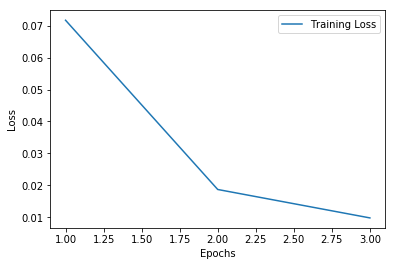

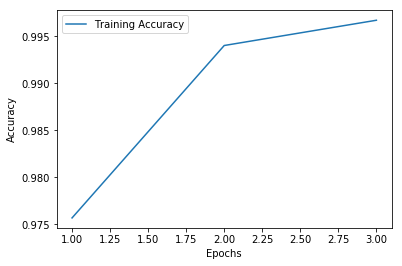

In [222]:
simple = simple_model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=3, batch_size=64)
plot_history(simple)

Train on 11765 samples, validate on 1962 samples
Epoch 1/3
11765/11765 [==============================] - 27s 2ms/step - loss: 0.0520 - acc: 0.9891 - val_loss: 0.0145 - val_acc: 0.9969
Epoch 2/3
11765/11765 [==============================] - 7s 605us/step - loss: 0.0171 - acc: 0.9963 - val_loss: 0.0022 - val_acc: 0.9990
Epoch 3/3
11765/11765 [==============================] - 7s 603us/step - loss: 0.0050 - acc: 0.9994 - val_loss: 4.1762e-04 - val_acc: 0.9995


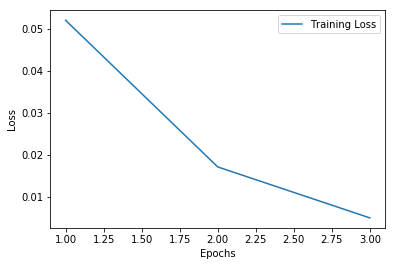

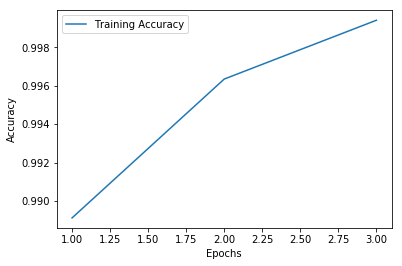

In [91]:
history= batch_norm_model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=3, batch_size=64)
plot_history(history)

Train on 11765 samples, validate on 1962 samples
Epoch 1/3
11765/11765 [==============================] - 27s 2ms/step - loss: 0.0719 - acc: 0.9844 - val_loss: 0.0086 - val_acc: 0.9975
Epoch 2/3
11765/11765 [==============================] - 7s 629us/step - loss: 0.0326 - acc: 0.9949 - val_loss: 0.0046 - val_acc: 0.9995
Epoch 3/3
11765/11765 [==============================] - 7s 632us/step - loss: 0.0319 - acc: 0.9949 - val_loss: 0.0071 - val_acc: 0.9969


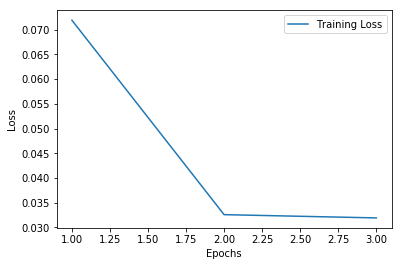

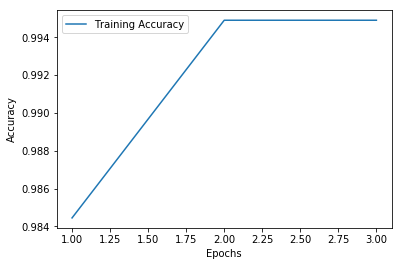

In [95]:
history= dropout_model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=3, batch_size=64)
plot_history(history)

**Wild transfer learning part**

Data (re)loading

In [170]:
x_train,y_train = train
x_test,y_test = test

train_mask = np.isin(y_train, range(5,9))
test_mask = np.isin(y_test, range(5,9))

x_train = x_train[train_mask]
x_test = x_test[test_mask]
y_test = y_test[test_mask]
y_train = y_train[train_mask]

y_train = y_train-5
y_test = y_test-5

y_train = to_categorical(y_train,num_classes=5)
x_train = x_train.reshape(-1,1,28,28)
y_test = to_categorical(y_test,num_classes=5)
x_test = x_test.reshape(-1,1,28,28)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [171]:
def get_transfer_model(simple_model,alpha=1.0,lr=0.001,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0):
    """
    Generates new model, by freezing intermediate layers
    """
    from keras.optimizers import Adam
    for layer in simple_model.layers:
        layer.trainable = False
    intermediate_layer_model = Model(inputs=simple_model.input,
                                     outputs=simple_model.get_layer("last").output)
    new_model = Sequential()
    new_model.add(intermediate_layer_model)
    new_model.add(Flatten())
    new_model.add(Dense(5,activation="softmax",kernel_initializer="he_uniform"))
    new_model.compile(Adam(lr,beta_1,beta_2,epsilon,decay),loss="categorical_crossentropy",metrics=['accuracy'])
    
    return new_model

In [190]:
def eval_transfer_model():
    new_model = get_transfer_model(simple_model)
    new_model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=3)

In [207]:
%%timeit -n1 -r3
eval_transfer_model()

Train on 23455 samples, validate on 3852 samples
Epoch 1/3
23455/23455 [==============================] - 38s 2ms/step - loss: 0.0737 - acc: 0.9764 - val_loss: 0.0540 - val_acc: 0.9868
Epoch 2/3
23455/23455 [==============================] - 18s 777us/step - loss: 0.0376 - acc: 0.9899 - val_loss: 0.0278 - val_acc: 0.9930
Epoch 3/3
23455/23455 [==============================] - 18s 774us/step - loss: 0.0232 - acc: 0.9937 - val_loss: 0.0536 - val_acc: 0.9881
Train on 23455 samples, validate on 3852 samples
Epoch 1/3
23455/23455 [==============================] - 38s 2ms/step - loss: 0.0679 - acc: 0.9780 - val_loss: 0.0360 - val_acc: 0.9904
Epoch 2/3
23455/23455 [==============================] - 18s 774us/step - loss: 0.0307 - acc: 0.9905 - val_loss: 0.0450 - val_acc: 0.9891
Epoch 3/3
23455/23455 [==============================] - 18s 779us/step - loss: 0.0250 - acc: 0.9927 - val_loss: 0.0399 - val_acc: 0.9907
Train on 23455 samples, validate on 3852 samples
Epoch 1/3
23455/23455 [======

In [ ]:
print("Took:"+str(end-start))

Now let's cash layer data

In [224]:
def train_cached_model(simple_model,alpha=1.0,lr=0.001,beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0,last="last",unfreeze=False):
    """
    Generates new model, by freezing intermediate layers
    """
    from keras.optimizers import Adam
    if unfreeze:
        for layer in simple_model.layers:
            layer.trainable = False
    else:
         for layer in simple_model.layers[:2]:
            layer.trainable = False

    intermediate_layer_model = Model(inputs=simple_model.input,
                                     outputs=simple_model.get_layer(last).output)
    x_ = intermediate_layer_model.predict(x_train)
    new_model = Sequential()
    new_model.add(Flatten())
    new_model.add(Dense(5,activation="softmax",kernel_initializer="he_uniform"))
    new_model.compile(Adam(lr,beta_1,beta_2,epsilon,decay),loss="categorical_crossentropy",metrics=['accuracy'])
    history = new_model.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=3)
    

In [223]:
train_cached_model(simple_model,last="last")

Train on 23455 samples, validate on 3852 samples
Epoch 1/3
23455/23455 [==============================] - 37s 2ms/step - loss: 0.2909 - acc: 0.9235 - val_loss: 0.1723 - val_acc: 0.9499
Epoch 2/3
23455/23455 [==============================] - 16s 694us/step - loss: 0.1489 - acc: 0.9557 - val_loss: 0.1479 - val_acc: 0.9535
Epoch 3/3
23455/23455 [==============================] - 16s 700us/step - loss: 0.1297 - acc: 0.9598 - val_loss: 0.1351 - val_acc: 0.9582


In [ ]:
train_cached_model(simple_model,last="prev")

In [225]:
train_cached_model(simple_model,last="prev",unfreeze=True)

Train on 23455 samples, validate on 3852 samples
Epoch 1/3
23455/23455 [==============================] - 37s 2ms/step - loss: 0.2976 - acc: 0.9193 - val_loss: 0.1764 - val_acc: 0.9468
Epoch 2/3
23455/23455 [==============================] - 16s 700us/step - loss: 0.1490 - acc: 0.9548 - val_loss: 0.1474 - val_acc: 0.9540
Epoch 3/3
23455/23455 [==============================] - 16s 702us/step - loss: 0.1293 - acc: 0.9601 - val_loss: 0.1361 - val_acc: 0.9577
